<a href="https://www.kaggle.com/code/hnaw257/facerecognition-task3-tunning-pca?scriptVersionId=164398672" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.datasets import fetch_lfw_people 
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person = 70, funneled=False) 
  
n_samples, h, w = lfw_people.images.shape 
  
X = lfw_people.data 
n_features = X.shape[1] 
  
y = lfw_people.target 
target_names = lfw_people.target_names 
n_classes = target_names.shape[0] 
  
# Print Details about dataset 
print("Number of Data Samples: % d" % n_samples) 
print("Size of a data sample: % d" % n_features) 
print("Number of Class Labels: % d" % n_classes)

Number of Data Samples:  1288
Size of a data sample:  2914
Number of Class Labels:  7


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y) 

In [4]:
n_components = 150
  
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Euclidean

In [5]:
y_predict = []
for i in range(len(X_test_reduced)):
    min_ = np.argmin(np.sqrt(np.sum((X_train_reduced - X_test_reduced[i])**2,axis=1)))
    y_predict.append(y_train[min_])

In [6]:
print(classification_report(y_test, y_predict, target_names = target_names)) 

                   precision    recall  f1-score   support

     Ariel Sharon       0.33      0.32      0.32        19
     Colin Powell       0.48      0.54      0.51        59
  Donald Rumsfeld       0.41      0.40      0.41        30
    George W Bush       0.59      0.65      0.62       133
Gerhard Schroeder       0.11      0.07      0.09        27
      Hugo Chavez       0.25      0.11      0.15        18
       Tony Blair       0.38      0.39      0.38        36

         accuracy                           0.48       322
        macro avg       0.37      0.35      0.35       322
     weighted avg       0.46      0.48      0.46       322



****

**Set up dataframe for model results storage**

In [7]:
model_scores = {}
prediction_results = {}

# Logistic Regression

In [8]:
lr = LogisticRegression(multi_class='ovr', solver='liblinear')
lr.fit(X_train_reduced, y_train)
y_predict = lr.predict(X_test_reduced)

In [9]:
print(classification_report(y_test, y_predict, target_names = target_names)) 

                   precision    recall  f1-score   support

     Ariel Sharon       0.87      0.68      0.76        19
     Colin Powell       0.83      0.88      0.85        59
  Donald Rumsfeld       0.83      0.80      0.81        30
    George W Bush       0.85      0.92      0.89       133
Gerhard Schroeder       0.78      0.52      0.62        27
      Hugo Chavez       0.67      0.44      0.53        18
       Tony Blair       0.76      0.86      0.81        36

         accuracy                           0.82       322
        macro avg       0.80      0.73      0.75       322
     weighted avg       0.82      0.82      0.82       322



*****

# PCA - TUNNING PROCESS

In [10]:
from sklearn.model_selection import KFold
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Support Vector Machine 

**Normal**

In [11]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train_reduced, y_train)
y_pred = svm.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.7795031055900621
recall: 0.6892693463548568
precision: 0.7043586373943517
f1-score: 0.6917522899604667
roc_auc:  0.8245840279990089


**Tunning**

In [12]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']),
        'C': trial.suggest_loguniform('C', 1e-5, 1e5),
        'gamma': trial.suggest_loguniform('gamma', 1e-5, 1e5),
        # 'degree': trial.suggest_int('degree', 2, 5),  # for polynomial kernel
        'tol': trial.suggest_loguniform('tol', 1e-4, 1e-2),
        'shrinking': trial.suggest_categorical('shrinking', [True, False]),
    }
    
    # Create KNN model with tuned hyperparameters
    model = SVC(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [13]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = SVC(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['svc'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'SVM'
model_scores[model_name] = [accuracy,recall,f1,precision,roc_auc_macro]

[I 2024-02-26 14:30:41,888] A new study created in memory with name: no-name-a9704db7-3c40-4b2c-88c8-c17080603a17
[I 2024-02-26 14:30:42,198] Trial 0 finished with value: 0.41097163613054855 and parameters: {'kernel': 'poly', 'C': 0.11826281968696145, 'gamma': 0.00019389130756525264, 'tol': 0.00013794704858235263, 'shrinking': True}. Best is trial 0 with value: 0.41097163613054855.
[I 2024-02-26 14:30:43,023] Trial 1 finished with value: 0.4130441749906522 and parameters: {'kernel': 'rbf', 'C': 21706.639101825145, 'gamma': 0.11558092806639261, 'tol': 0.007444635238675238, 'shrinking': False}. Best is trial 1 with value: 0.4130441749906522.
[I 2024-02-26 14:30:43,338] Trial 2 finished with value: 0.41097163613054855 and parameters: {'kernel': 'poly', 'C': 1714.3569851332943, 'gamma': 0.00011174460664129772, 'tol': 0.00854842032721519, 'shrinking': True}. Best is trial 1 with value: 0.4130441749906522.
[I 2024-02-26 14:30:43,983] Trial 3 finished with value: 0.5786496447839323 and parame

Best params found : {'kernel': 'linear', 'C': 0.1031059214226829, 'gamma': 4.133948702669331e-05, 'tol': 0.0015279955480528669, 'shrinking': True}
accuracy: 0.8260869565217391
recall: 0.7138492248916615
precision: 0.8052672977355373
f1-score: 0.7480885370750668
roc_auc:  0.8392392649448979


In [14]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

SVM

                   precision    recall  f1-score   support

     Ariel Sharon       0.87      0.68      0.76        19
     Colin Powell       0.83      0.88      0.85        59
  Donald Rumsfeld       0.83      0.80      0.81        30
    George W Bush       0.85      0.92      0.89       133
Gerhard Schroeder       0.78      0.52      0.62        27
      Hugo Chavez       0.67      0.44      0.53        18
       Tony Blair       0.76      0.86      0.81        36

         accuracy                           0.82       322
        macro avg       0.80      0.73      0.75       322
     weighted avg       0.82      0.82      0.82       322



# Decision Tree

**Normal**

In [15]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_reduced, y_train)
y_pred = dt.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

svm = SVC(kernel='linear')
svm.fit(X_train_reduced, y_train)
y_pred = svm.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
# Assuming 'label_' prefix for clarity
y_test_onehot = pd.get_dummies(y_test, prefix='label_')
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot,
                              average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.37888198757763975
recall: 0.26194751069225386
precision: 0.2588648436976899
f1-score: 0.2588670189647468
roc_auc:  0.5720895551806623
accuracy: 0.7795031055900621
recall: 0.6892693463548568
precision: 0.7043586373943517
f1-score: 0.6917522899604667
roc_auc:  0.8245840279990089


**Tunning**

In [16]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    hyperparams = {
        "max_depth" : trial.suggest_int("max_depth", 2, 10),
        "min_samples_split" : trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 10),
        "criterion" : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'random_state': trial.suggest_categorical('random_state', [42])

    }

    # Create KNN model with tuned hyperparameters
    model = DecisionTreeClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [17]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = DecisionTreeClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['decison tree'] = list(y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Decision Tree'
model_scores[model_name] = [accuracy, recall,f1,precision,roc_auc_macro]

[I 2024-02-26 14:31:34,339] A new study created in memory with name: no-name-75495670-32c3-4843-bb9a-f5e20fabf07a
[I 2024-02-26 14:31:34,623] Trial 0 finished with value: 0.4109876609155494 and parameters: {'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'criterion': 'gini', 'random_state': 42}. Best is trial 0 with value: 0.4109876609155494.
[I 2024-02-26 14:31:35,015] Trial 1 finished with value: 0.40271887185513594 and parameters: {'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 8, 'criterion': 'gini', 'random_state': 42}. Best is trial 0 with value: 0.4109876609155494.
[I 2024-02-26 14:31:35,874] Trial 2 finished with value: 0.4037444580951872 and parameters: {'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 9, 'criterion': 'entropy', 'random_state': 42}. Best is trial 0 with value: 0.4109876609155494.
[I 2024-02-26 14:31:36,404] Trial 3 finished with value: 0.39026227231451316 and parameters: {'max_depth': 3, 'min_samples_split': 11, 'min_sam

Best params found : {'max_depth': 5, 'min_samples_split': 17, 'min_samples_leaf': 8, 'criterion': 'entropy', 'random_state': 42}
accuracy: 0.40993788819875776
recall: 0.262970717080568
precision: 0.35629454798890015
f1-score: 0.2695243693088521
roc_auc:  0.5720687411317285


In [18]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Decision Tree

                   precision    recall  f1-score   support

     Ariel Sharon       0.87      0.68      0.76        19
     Colin Powell       0.83      0.88      0.85        59
  Donald Rumsfeld       0.83      0.80      0.81        30
    George W Bush       0.85      0.92      0.89       133
Gerhard Schroeder       0.78      0.52      0.62        27
      Hugo Chavez       0.67      0.44      0.53        18
       Tony Blair       0.76      0.86      0.81        36

         accuracy                           0.82       322
        macro avg       0.80      0.73      0.75       322
     weighted avg       0.82      0.82      0.82       322



# KNN Classifier

**Normal**

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_reduced, y_train)
y_pred = knn.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)


accuracy: 0.5186335403726708
recall: 0.36767588192973694
precision: 0.4702233034918616
f1-score: 0.3651427621036169
roc_auc:  0.635901483661499


**Tunning**

In [20]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

def objective(trial):
    hyperparams = {
        'n_neighbors': trial.suggest_int("n_neighbors", 5, 100),
        'weights' : trial.suggest_categorical("weights", ["uniform", "distance"]),
        'metric' : trial.suggest_categorical("metric", ["euclidean", "manhattan", "minkowski"]),
        'algorithm':trial.suggest_categorical('algorithm',['auto', 'ball_tree', 'kd_tree', 'brute']),
        'n_jobs': -1
    }
    
    # Create KNN model with tuned hyperparameters
    model = KNeighborsClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [21]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 200)
best_params = study.best_params
print("Best params found :", best_params)

final_model =KNeighborsClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['KNN'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'K-Nearest Neighbors'
model_scores[model_name] = [accuracy, recall, f1,precision, roc_auc_macro]

[I 2024-02-26 14:32:42,122] A new study created in memory with name: no-name-66826e25-87a0-4d8e-945e-0193c6737685
[I 2024-02-26 14:32:42,270] Trial 0 finished with value: 0.44202232786710105 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'brute'}. Best is trial 0 with value: 0.44202232786710105.
[I 2024-02-26 14:32:42,640] Trial 1 finished with value: 0.46167939746808395 and parameters: {'n_neighbors': 53, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'kd_tree'}. Best is trial 1 with value: 0.46167939746808395.
[I 2024-02-26 14:32:42,967] Trial 2 finished with value: 0.440980716842049 and parameters: {'n_neighbors': 99, 'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'kd_tree'}. Best is trial 1 with value: 0.46167939746808395.
[I 2024-02-26 14:32:43,184] Trial 3 finished with value: 0.4792906361839645 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'ball_tree'}. Best is t

Best params found : {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'auto'}
accuracy: 0.5962732919254659
recall: 0.38976429505294036
precision: 0.672851291054056
f1-score: 0.4181626278066933
roc_auc:  0.650575844861349


In [22]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

K-Nearest Neighbors

                   precision    recall  f1-score   support

     Ariel Sharon       0.87      0.68      0.76        19
     Colin Powell       0.83      0.88      0.85        59
  Donald Rumsfeld       0.83      0.80      0.81        30
    George W Bush       0.85      0.92      0.89       133
Gerhard Schroeder       0.78      0.52      0.62        27
      Hugo Chavez       0.67      0.44      0.53        18
       Tony Blair       0.76      0.86      0.81        36

         accuracy                           0.82       322
        macro avg       0.80      0.73      0.75       322
     weighted avg       0.82      0.82      0.82       322



****

# Gassian NB

**Pre-tunning**

In [23]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_reduced, y_train)

y_pred = gnb.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovr')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)


accuracy: 0.7018633540372671
recall: 0.5987965272341466
precision: 0.6628543350114623
f1-score: 0.6154098136960365


**Tunning**

In [24]:
def objective(trial):
    hyperparams = {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-9, 1e-4, log = True)
    }
    
    model = GaussianNB(**hyperparams)
    scores = cross_val_score(model, X_train_reduced, y_train, cv = kf,scoring = 'accuracy')
    return np.mean(scores)

In [25]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = GaussianNB(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['gnb'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Gaussian Naives Bayes'
model_scores[model_name] = [accuracy, recall,f1,precision,roc_auc_macro]

[I 2024-02-26 14:33:12,094] A new study created in memory with name: no-name-2317eef7-d064-4aff-8276-6b96cd5df201
[I 2024-02-26 14:33:12,120] Trial 0 finished with value: 0.6170022968858501 and parameters: {'var_smoothing': 2.2964213111398227e-09}. Best is trial 0 with value: 0.6170022968858501.
[I 2024-02-26 14:33:12,148] Trial 1 finished with value: 0.6180385663159018 and parameters: {'var_smoothing': 2.2644939797220523e-05}. Best is trial 1 with value: 0.6180385663159018.
[I 2024-02-26 14:33:12,177] Trial 2 finished with value: 0.6170022968858501 and parameters: {'var_smoothing': 4.257150037008588e-05}. Best is trial 1 with value: 0.6180385663159018.
[I 2024-02-26 14:33:12,207] Trial 3 finished with value: 0.6170022968858501 and parameters: {'var_smoothing': 1.7850429484938969e-07}. Best is trial 1 with value: 0.6180385663159018.
[I 2024-02-26 14:33:12,234] Trial 4 finished with value: 0.6170022968858501 and parameters: {'var_smoothing': 2.2836967890496799e-07}. Best is trial 1 with

Best params found : {'var_smoothing': 2.2644939797220523e-05}
accuracy: 0.6956521739130435
recall: 0.5966482995220092
precision: 0.6588409889430297
f1-score: 0.6116818789196777
roc_auc:  0.7692721315802175


In [26]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Gaussian Naives Bayes

                   precision    recall  f1-score   support

     Ariel Sharon       0.87      0.68      0.76        19
     Colin Powell       0.83      0.88      0.85        59
  Donald Rumsfeld       0.83      0.80      0.81        30
    George W Bush       0.85      0.92      0.89       133
Gerhard Schroeder       0.78      0.52      0.62        27
      Hugo Chavez       0.67      0.44      0.53        18
       Tony Blair       0.76      0.86      0.81        36

         accuracy                           0.82       322
        macro avg       0.80      0.73      0.75       322
     weighted avg       0.82      0.82      0.82       322



****

# Logistic Regression

**Normal**

In [27]:
lr = LogisticRegression()
lr.fit(X_train_reduced, y_train)
y_pred = lr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# # One-hot encoding for probability calculation (adapt if necessary)
# y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
# y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# # ROC AUC score with multiclass handling
# roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
# print('roc_auc: ', roc_auc_macro)

accuracy: 0.8291925465838509
recall: 0.7358719640101059
precision: 0.8015371035672638
f1-score: 0.7602174407729008


**Tunning**

In [28]:
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')


def objective(trial):
    hyperparams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'saga']),
        'penalty': trial.suggest_categorical('penalty', ['l2']),
        'multi_class': trial.suggest_categorical('multi_class', ['ovr']),
        'C': trial.suggest_loguniform("C", 1e-3, 1e3),
        'n_jobs': -1
    }

    model = LogisticRegression(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [29]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = LogisticRegression(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['logistic regression'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Logistic Regression'
model_scores[model_name] = [accuracy, recall,f1,precision,roc_auc_macro]

[I 2024-02-26 14:33:17,223] A new study created in memory with name: no-name-ffdbf6ca-84c8-4108-b18a-06e171287e19
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converg

Best params found : {'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'C': 0.28669966604710934}
accuracy: 0.8416149068322981
recall: 0.7439920422525239
precision: 0.8294577604745479
f1-score: 0.7751479108005711
roc_auc:  0.8562521434667618


In [30]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Logistic Regression

                   precision    recall  f1-score   support

     Ariel Sharon       0.87      0.68      0.76        19
     Colin Powell       0.83      0.88      0.85        59
  Donald Rumsfeld       0.83      0.80      0.81        30
    George W Bush       0.85      0.92      0.89       133
Gerhard Schroeder       0.78      0.52      0.62        27
      Hugo Chavez       0.67      0.44      0.53        18
       Tony Blair       0.76      0.86      0.81        36

         accuracy                           0.82       322
        macro avg       0.80      0.73      0.75       322
     weighted avg       0.82      0.82      0.82       322



***

# Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

**Normal**

In [32]:
rfr = RandomForestClassifier(random_state=42)
rfr.fit(X_train_reduced,y_train)
y_pred = rfr.predict(X_test_reduced)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# One-hot encoding for probability calculation (adapt if necessary)
y_test_onehot = pd.get_dummies(y_test, prefix='label_')  # Assuming 'label_' prefix for clarity
y_pred_onehot = pd.get_dummies(y_pred, prefix='label_')

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')  # Specify 'ovo' or 'ovr'

print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

accuracy: 0.5124223602484472
recall: 0.22267958030669896
precision: 0.32944967099896677
f1-score: 0.19260559294499885
roc_auc:  0.4823247535181145


**Tunning**

In [33]:
import optuna


def objective(trial):
    hyperparams = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
        'n_jobs': -1
    }

    model = RandomForestClassifier(**hyperparams)
    scores = cross_val_score(model, X_train_reduced,
                             y_train, cv=kf, scoring='accuracy')
    return np.mean(scores)

In [34]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)
best_params = study.best_params
print("Best params found :", best_params)

final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

[I 2024-02-26 14:36:39,475] A new study created in memory with name: no-name-fcffc81d-4863-4968-9536-a3f96008c14b
[I 2024-02-26 14:36:55,460] Trial 0 finished with value: 0.41925644997596284 and parameters: {'n_estimators': 616, 'max_depth': 17, 'min_samples_split': 8, 'random_state': 42, 'min_samples_leaf': 29}. Best is trial 0 with value: 0.41925644997596284.
[I 2024-02-26 14:37:09,837] Trial 1 finished with value: 0.4378932749318947 and parameters: {'n_estimators': 507, 'max_depth': 13, 'min_samples_split': 14, 'random_state': 42, 'min_samples_leaf': 14}. Best is trial 1 with value: 0.4378932749318947.
[I 2024-02-26 14:37:29,690] Trial 2 finished with value: 0.42132898883606645 and parameters: {'n_estimators': 757, 'max_depth': 43, 'min_samples_split': 17, 'random_state': 42, 'min_samples_leaf': 23}. Best is trial 1 with value: 0.4378932749318947.
[I 2024-02-26 14:37:44,687] Trial 3 finished with value: 0.44203301105710163 and parameters: {'n_estimators': 511, 'max_depth': 46, 'min_

Best params found : {'n_estimators': 104, 'max_depth': 28, 'min_samples_split': 4, 'random_state': 42, 'min_samples_leaf': 3}


0.4968944099378882

In [35]:
final_model = RandomForestClassifier(**best_params)
final_model.fit(X_train_reduced, y_train)
y_pred = final_model.predict(X_test_reduced)
prediction_results['random forest'] = y_pred 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')


# Fit a label binarizer to get all possible classes
label_binarizer = LabelBinarizer()
label_binarizer.fit(y_test)

# Transform y_test and y_pred to one-hot encoding with the same set of columns
y_test_onehot = pd.DataFrame(label_binarizer.transform(
    y_test), columns=label_binarizer.classes_)
y_pred_onehot = pd.DataFrame(label_binarizer.transform(
    y_pred), columns=label_binarizer.classes_)

# Ensure both sets have the same columns
all_columns = set(y_test_onehot.columns).union(set(y_pred_onehot.columns))
y_test_onehot = y_test_onehot.reindex(columns=all_columns, fill_value=0)
y_pred_onehot = y_pred_onehot.reindex(columns=all_columns, fill_value=0)

# ROC AUC score with multiclass handling
roc_auc_macro = roc_auc_score(
    y_test_onehot, y_pred_onehot, average='macro', multi_class='ovo')


print("accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1-score:", f1)
print('roc_auc: ', roc_auc_macro)

# Save model result
model_name = 'Random Forest'
model_scores[model_name] = [accuracy, recall,f1,precision,roc_auc_macro]

accuracy: 0.4968944099378882
recall: 0.21132633844498253
precision: 0.33547665641599106
f1-score: 0.18655116493058202
roc_auc:  0.5447576916956123


In [36]:
print(f'{model_name}\n')
print('=' * 50)
print(classification_report(y_test, y_predict, target_names=target_names))

Random Forest

                   precision    recall  f1-score   support

     Ariel Sharon       0.87      0.68      0.76        19
     Colin Powell       0.83      0.88      0.85        59
  Donald Rumsfeld       0.83      0.80      0.81        30
    George W Bush       0.85      0.92      0.89       133
Gerhard Schroeder       0.78      0.52      0.62        27
      Hugo Chavez       0.67      0.44      0.53        18
       Tony Blair       0.76      0.86      0.81        36

         accuracy                           0.82       322
        macro avg       0.80      0.73      0.75       322
     weighted avg       0.82      0.82      0.82       322



****

****

# SUMMARY

**Classification over all models**

In [37]:
results_df = pd.DataFrame(model_scores, index=['Accuracy', 'Recall','F1 Score','Precision','ROC AUC']).T
results_df

,Accuracy,Recall,F1 Score,Precision,ROC AUC
SVM,0.826087,0.713849,0.748089,0.805267,0.839239
Decision Tree,0.409938,0.262971,0.269524,0.356295,0.572069
K-Nearest Neighbors,0.596273,0.389764,0.418163,0.672851,0.650576
Gaussian Naives Bayes,0.695652,0.596648,0.611682,0.658841,0.769272
Logistic Regression,0.841615,0.743992,0.775148,0.829458,0.856252
Random Forest,0.496894,0.211326,0.186551,0.335477,0.544758


In [38]:
# dump prediction results
# import json
# with open("/kaggle/working/predict.json", "w") as json_file:
#     json.dump(prediction_results, json_file)

****
## Visualization

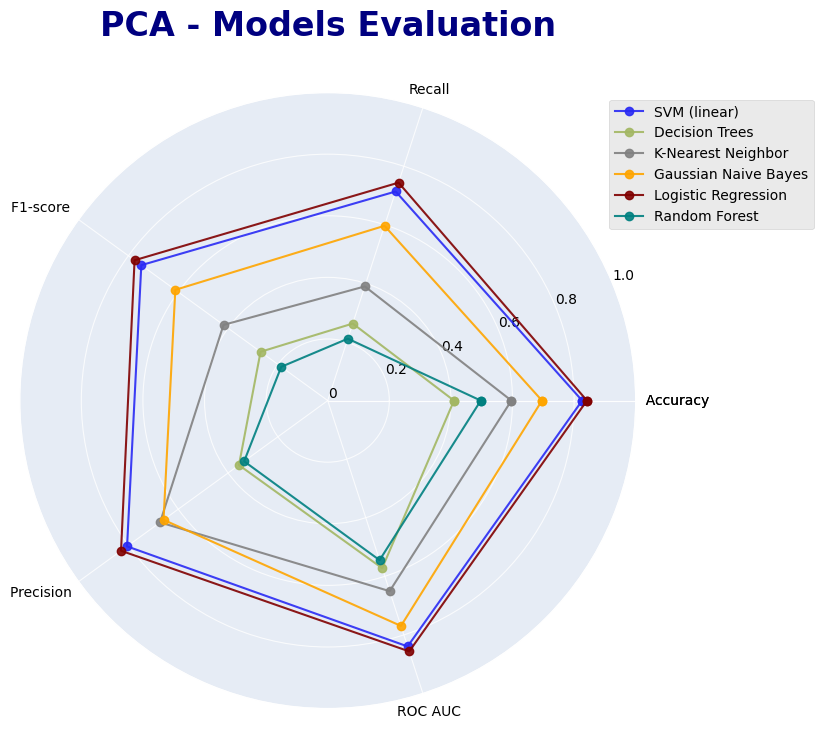

In [39]:
plt.style.use('ggplot')
# Data
labels = [(' '*10 +'Accuracy'), 'Recall', ('F1-score'+ ' ' * 10) , ('Precision'+ ' ' * 10), 'ROC AUC']
svm = results_df.loc['SVM'].tolist()
dt = results_df.loc['Decision Tree'].tolist()
knn = results_df.loc['K-Nearest Neighbors'].tolist()
gnb = results_df.loc['Gaussian Naives Bayes'].tolist()
lr = results_df.loc['Logistic Regression'].tolist()
rf = results_df.loc['Random Forest'].tolist()

# Number of variables we're plotting.
categories = labels
N = len(categories)

# What will be the angle of each axis in the plot?
angles = np.linspace(0, 2*np.pi, len(labels), endpoint = False)
angles = np.concatenate((angles, [angles[0]]))


# Initialise the spider plot
plt.figure(figsize=(8, 8))  # Increase the size of the radar

# Draw one axe per variable + add labels yet
plt.xticks(angles[:-1], categories, color='white')  # White labels
plt.yticks([i/10 for i in range(11)], ["{:.2f}".format(i/10) for i in range(11)], color="white", size=7)
plt.ylim(0, 1)

# Set gray background
ax = plt.subplot(111, polar=True, facecolor='#E6ECF5', alpha = 0.7)  

# Plot each classifier's data
for data, label, color in zip([svm, dt, knn, gnb, lr, rf],
                              ["SVM (linear)", "Decision Trees", "K-Nearest Neighbor",
                               "Gaussian Naive Bayes", "Logistic Regression", "Random Forest"],
                              ['#292AF4', '#A3B763', '#818181', 'orange', 'maroon', 'teal']):
 
    ax.plot(angles, data + data[:1], 'o-', linewidth=1.5, label=label, color=color, alpha = 0.9)
    ax.fill(angles, data + data[:1], alpha=0)  # Fill only the edges
    
# Modify grids
labels.append(labels[0])
ax.set_thetagrids(angles * 180/np.pi, labels, color = 'black')
plt.grid(True)

# Add labels for each coordinate system
# for angle, lab in zip(angles, labels):
# plt.annotate(labels[0], xy=(angles[0], 1.1), color='white', fontsize=10, ha='center')
# plt.annotate(labels[1], xy=(angles[1], 1.1), color='white', fontsize=10, ha='center')
# plt.annotate(labels[2], xy=(angles[2], 1.1), color='white', fontsize=10, ha='center')
# plt.annotate(labels[3], xy=(angles[3], 1.1), color='white', fontsize=10, ha='center')

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.title("PCA - Models Evaluation\n", size = 24,color='navy', weight = 'bold')
plt.grid(color='white', linestyle='-', alpha = 0.8)  # White grid lines
plt.yticks([0,0.2, 0.4, 0.6, 0.8, 1.0], ["0","0.2", "0.4", "0.6", "0.8", "1.0"],color="black", size=10)  # Custom y-ticks
plt.show()


In [40]:
# dump prediction results
import json
predictions = {}
for k in prediction_results.keys():
    predictions[k] = list(prediction_results[k])

# with open("/kaggle/working/prediction_results.json", "w") as json_file:
#     json.dump(predictions, json_file)

predictions

{'svc': [1,
  1,
  3,
  3,
  1,
  3,
  3,
  3,
  3,
  1,
  3,
  0,
  6,
  5,
  3,
  3,
  3,
  5,
  4,
  3,
  3,
  2,
  1,
  3,
  1,
  1,
  1,
  3,
  3,
  1,
  1,
  3,
  2,
  1,
  2,
  4,
  2,
  1,
  1,
  3,
  3,
  1,
  1,
  1,
  3,
  6,
  3,
  2,
  3,
  3,
  3,
  0,
  1,
  1,
  3,
  0,
  3,
  4,
  3,
  3,
  1,
  3,
  3,
  3,
  1,
  3,
  3,
  1,
  6,
  3,
  1,
  3,
  1,
  2,
  3,
  6,
  6,
  3,
  6,
  3,
  3,
  1,
  3,
  1,
  0,
  4,
  2,
  1,
  5,
  3,
  3,
  2,
  6,
  3,
  3,
  1,
  3,
  3,
  2,
  3,
  1,
  3,
  3,
  3,
  4,
  3,
  3,
  1,
  3,
  3,
  1,
  3,
  3,
  3,
  3,
  6,
  3,
  1,
  3,
  3,
  0,
  1,
  1,
  3,
  2,
  2,
  3,
  3,
  3,
  3,
  5,
  6,
  2,
  2,
  1,
  3,
  3,
  1,
  3,
  0,
  3,
  3,
  3,
  3,
  1,
  2,
  6,
  3,
  6,
  3,
  1,
  1,
  3,
  2,
  2,
  3,
  3,
  3,
  6,
  3,
  3,
  6,
  6,
  3,
  3,
  3,
  3,
  3,
  6,
  3,
  3,
  3,
  4,
  3,
  2,
  3,
  1,
  1,
  3,
  3,
  0,
  1,
  3,
  6,
  2,
  6,
  4,
  4,
  3,
  6,
  0,
  3,
  0,
  2,
  3,
  3,
  4,
  3,
  1